# Power Consumption Prediction 

## Overview
### The task
to estimate hourly power consumptions of today from the power consumptions history until today.

At 12 AM each day, forecasting module provides the estimated power consumptions of each hour on the day. 

Power Consumption Prediction is a task of regressions. Essentially, we can feed power consumption data in the past and features to the models to train and estimate.

Requirements are high accurate estimation. Also, computing speed may be required to provide estimation because faster computing allows to use as nearer data as possible to accurate estimation.

### Model
- Linear Regression

We used Linear Regression which is one of the most basic regression techniques.
We can also try Gaussian Process regression, Support Vector Regression, or any other regression models. Those models may give better performance however they require some tunings and computational cost. On the other hand Linear regression is very simple but it is very fast and tuning is not required. Also Linear regression can be a baseline of further improvement.

### Features
- power consumptions of previous 7 days from the target day
- hourly differences of power consumptions of previous 7 days from the target day

In terms of the data and features, we only used power consumption data to make them simple. We trained the models to estimate consumptions in a day by using previous 7 days data. Also, as extra features, we put difference between each hour and the previous hour to extract the daily trends.
This feature design allows to predict hour by hour by using like sliding windows.

### Overall test accuracy
#### Root Mean Square Error

798.7906

$\mathrm{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1}^{N}(truth - estim)^2}$

#### Match Rate (rate of overlapping region between truth and estimation)

0.9586
<img src="match_rate_example.png" width="200">

### Computational speed
Both training and prediction take less than 1 second.


### Plots prediction and truth
Each plot shows the day by day estimation result (blue line), truth (red line) and input (light coloured lines). 

Surprisingly, the estimations are more accurate than we thought, especially daily trends (peaks and bottoms). However these are not perfect enough. To improve the performance, we can add some features such as weather information and seasonally trends. Also we can try more complicated models.

Estimations on Mondays, Saturdays, and Sundays seemed to be less accurate. The reason is that power consumptions on those days are different from the previous days. Modeling on each week day would solve this issue.

# import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE

from matplotlib import pyplot as plt
%matplotlib inline

import plotter

sys.path.append(os.path.join('..', 'hec'))
import utils.data_handler as dh
from utils.logger import logger
import model.preprocessing as pp
import model.model as mdl
from utils.eval import match_rate
logger.setLevel('INFO')

# Data Loading

In [3]:
data_dir = '../data/'
n_data_to_load = 2
data = dh.data_loader(data_dir, n_data_to_load)

2019-11-26 21:17:11,756|INFO|data_handler.py(23) data_loader|../data/AEP_hourly.csv
2019-11-26 21:17:12,013|INFO|data_handler.py(48) load_csv_to_df|../data/AEP_hourly.csv loaded
2019-11-26 21:17:12,210|INFO|data_handler.py(23) data_loader|../data/COMED_hourly.csv
2019-11-26 21:17:12,318|INFO|data_handler.py(48) load_csv_to_df|../data/COMED_hourly.csv loaded
2019-11-26 21:17:12,377|INFO|data_handler.py(33) data_loader|total: 2 dataset
2019-11-26 21:17:12,378|INFO|data_handler.py(34) data_loader|no| dataset names
2019-11-26 21:17:12,379|INFO|data_handler.py(35) data_loader|--|--------------------
2019-11-26 21:17:12,380|INFO|data_handler.py(37) data_loader| 1| AEP_hourly (121296, 1)
2019-11-26 21:17:12,403|INFO|data_handler.py(37) data_loader| 2| COMED_hourly (66504, 1)


# data to feature vectors and target vectors
Training and testing data were divided by the ratio of 7 : 3. First 70% of the time series data was assigned for training and the rest of them was for testing.

feat_train and feat_test are the input to estimate the target values tar_train and tar_test.
As the features, we set power consumptions of 7 days before the target and the differences during the 7 days.
They have shapes of (data_length, feature_length). The feature_length is 24 hours * 7 days + 24 hours * 7 days - 1.
tar_train and tar_test have shapes of (data_length, 24 hours).

feat_train and tar_train were used for training the models. feat_test was used for estimation, and tar_test was used for checking the estimation results.

There are also some preprocessing. Power consumptions are scaled between 0 and 1. To make the structured data, if the data started from the hours which are not 12 AM, some data before 0 AM were removed.

In [4]:
df = list(data.values())[1]
n_days = 7
norm_prm_file_name = 'norm_prm_%s.pkl' % list(data.keys())[1]
ret = pp.data_preparation(df, norm_prm_file_name, n_days)
feat_train, tar_train, feat_test, tar_test, idx_train, idx_test = ret

2019-11-26 21:17:12,509|INFO|preprocessing.py(99) array_min_max_norm|transform using parameters from file
2019-11-26 21:17:12,510|INFO|preprocessing.py(260) load|norm_prm_COMED_hourly.pkl loaded.
2019-11-26 21:17:12,511|INFO|preprocessing.py(314) transform|MinMax normalisation transforming the data
2019-11-26 21:17:12,529|INFO|preprocessing.py(320) transform|MinMax normalisation done
2019-11-26 21:17:12,685|INFO|preprocessing.py(67) split_df_train_test|data shifting to align hour 0.


# Linear Regression
Linear regression is one of the most simple regression model. Before using more complicated models, we should see the estimation results of simpler models. We can obtain the estimation results to execute the cell below.

In [5]:
l_r = mdl.Model()
l_r.fit(feat_train, tar_train)

2019-11-26 21:17:16,631|INFO|model.py(32) fit|fit started.
2019-11-26 21:17:16,632|INFO|model.py(34) fit|features size: (1931, 335), target_size: (1931, 24)
2019-11-26 21:17:16,917|INFO|model.py(37) fit|fit finished.


In [6]:
l_r_model = l_r.get_model()
print('train score:', l_r_model.score(feat_train, tar_train))
print('test score :',l_r_model.score(feat_test, tar_test))

train score: 0.8776517039101546
test score : 0.8347448835533094


/anaconda2/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/anaconda2/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

# Prediction from trained model

In [7]:
pred_train = l_r.predict(feat_train)
pred_test = l_r.predict(feat_test)

2019-11-26 21:17:17,008|INFO|model.py(46) predict|prediction started.
2019-11-26 21:17:17,010|WARNING|model.py(48) predict|features are not scaled. do preprocessing.
2019-11-26 21:17:17,016|INFO|model.py(50) predict|prediction finished.
2019-11-26 21:17:17,017|INFO|model.py(46) predict|prediction started.
2019-11-26 21:17:17,019|WARNING|model.py(48) predict|features are not scaled. do preprocessing.
2019-11-26 21:17:17,030|INFO|model.py(50) predict|prediction finished.


# Estimation results from Linear Regression

## closed evaluation (training v estimation from training) data

### data for plotting
data is put into DataFrame again for visualisations. Inverse normalisation also applied.

In [8]:
ret = pp.post_process_array_to_df(feat_train, pred_train, tar_train, n_days, idx_train)
df_feat_nrm_trn, df_pred_nrm_trn, df_tar_nrm_trn = ret
ret = pp.post_process_inverse_norm(df_feat_nrm_trn, df_pred_nrm_trn, df_tar_nrm_trn, norm_prm_file_name)
df_feat_trn, df_pred_trn, df_tar_trn = ret

2019-11-26 21:17:17,075|INFO|preprocessing.py(145) df_inversed_min_max_norm|transform using parameters from file
2019-11-26 21:17:17,076|INFO|preprocessing.py(260) load|norm_prm_COMED_hourly.pkl loaded.
2019-11-26 21:17:17,077|INFO|preprocessing.py(331) inverse_transform|Inverse MinMax normalisation transforming the data
2019-11-26 21:17:17,121|INFO|preprocessing.py(337) inverse_transform|MinMax normalisation done
2019-11-26 21:17:17,139|INFO|preprocessing.py(145) df_inversed_min_max_norm|transform using parameters from file
2019-11-26 21:17:17,140|INFO|preprocessing.py(260) load|norm_prm_COMED_hourly.pkl loaded.
2019-11-26 21:17:17,141|INFO|preprocessing.py(331) inverse_transform|Inverse MinMax normalisation transforming the data
2019-11-26 21:17:17,147|INFO|preprocessing.py(337) inverse_transform|MinMax normalisation done
2019-11-26 21:17:17,152|INFO|preprocessing.py(145) df_inversed_min_max_norm|transform using parameters from file
2019-11-26 21:17:17,154|INFO|preprocessing.py(260) 

### Day by day Root Mean Square Error (RMSE)
The plot below illustrates day by day root mean square between truth and estimations. x-axis is the days and y-axis has RMSE. RMSE gives the distance between truth and prediction which means smaller values are the better.

$\mathrm{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1}^{N}(truth - estim)^2}$

The RMSE at middle of the graph is higher than the other area. This may be the reason that features of this model is based on previous 7 days and on these days, temperatures might have changed significantly. For further investigation, some extra information such as weather histories may be required.

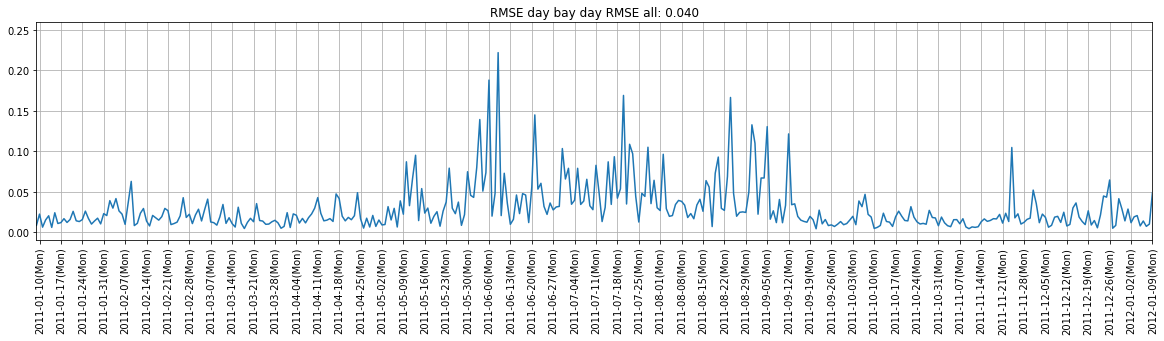

In [9]:
plotter.plot_rmse_day_by_day(df_tar_nrm_trn, df_pred_nrm_trn)

### Overall RMSE and Match rate
Since RMSE gives the distance between truth and prediction. It is good for comparison in same scale but it is difficult to see absolute performance. So, we introduced Match rate.

Match rate gives the rate how much truth and prediction overlap each other.
```
upper = max([truth, estim])
lower = min([truth, estim])
match_rate = lower.sum() / upper.sum()
```

In [10]:
print('RMSE(normalised):', np.sqrt(MSE(df_tar_nrm_trn.values.flatten(), df_pred_nrm_trn.values.flatten())))
print('RMSE            :', np.sqrt(MSE(df_tar_trn.values.flatten(), df_pred_trn.values.flatten())))
print('Match Rate      :', match_rate(df_tar_trn.values.flatten(), df_pred_trn.values.flatten()))

RMSE(normalised): 0.04043416278004233
RMSE            : 667.8106324751792
Match Rate      : 0.9656878103008741


### Plots Training data and closed prediction
Each plot shows the day by day estimation result (blue line), truth (red line) and input (light coloured lines). 

Surprisingly, the estimations are more accurate than we thought, especially daily trends (peaks and bottoms). However these are not perfect enough. To improve the performance, we can add some features such as weather information and seasonally trends. Also we can try more complicated models.

Estimations on Mondays, Saturdays, and Sundays seemed to be less accurate. The reason is that power consumptions on those days are different from the previous days. Modeling on each week day would solve this issue.

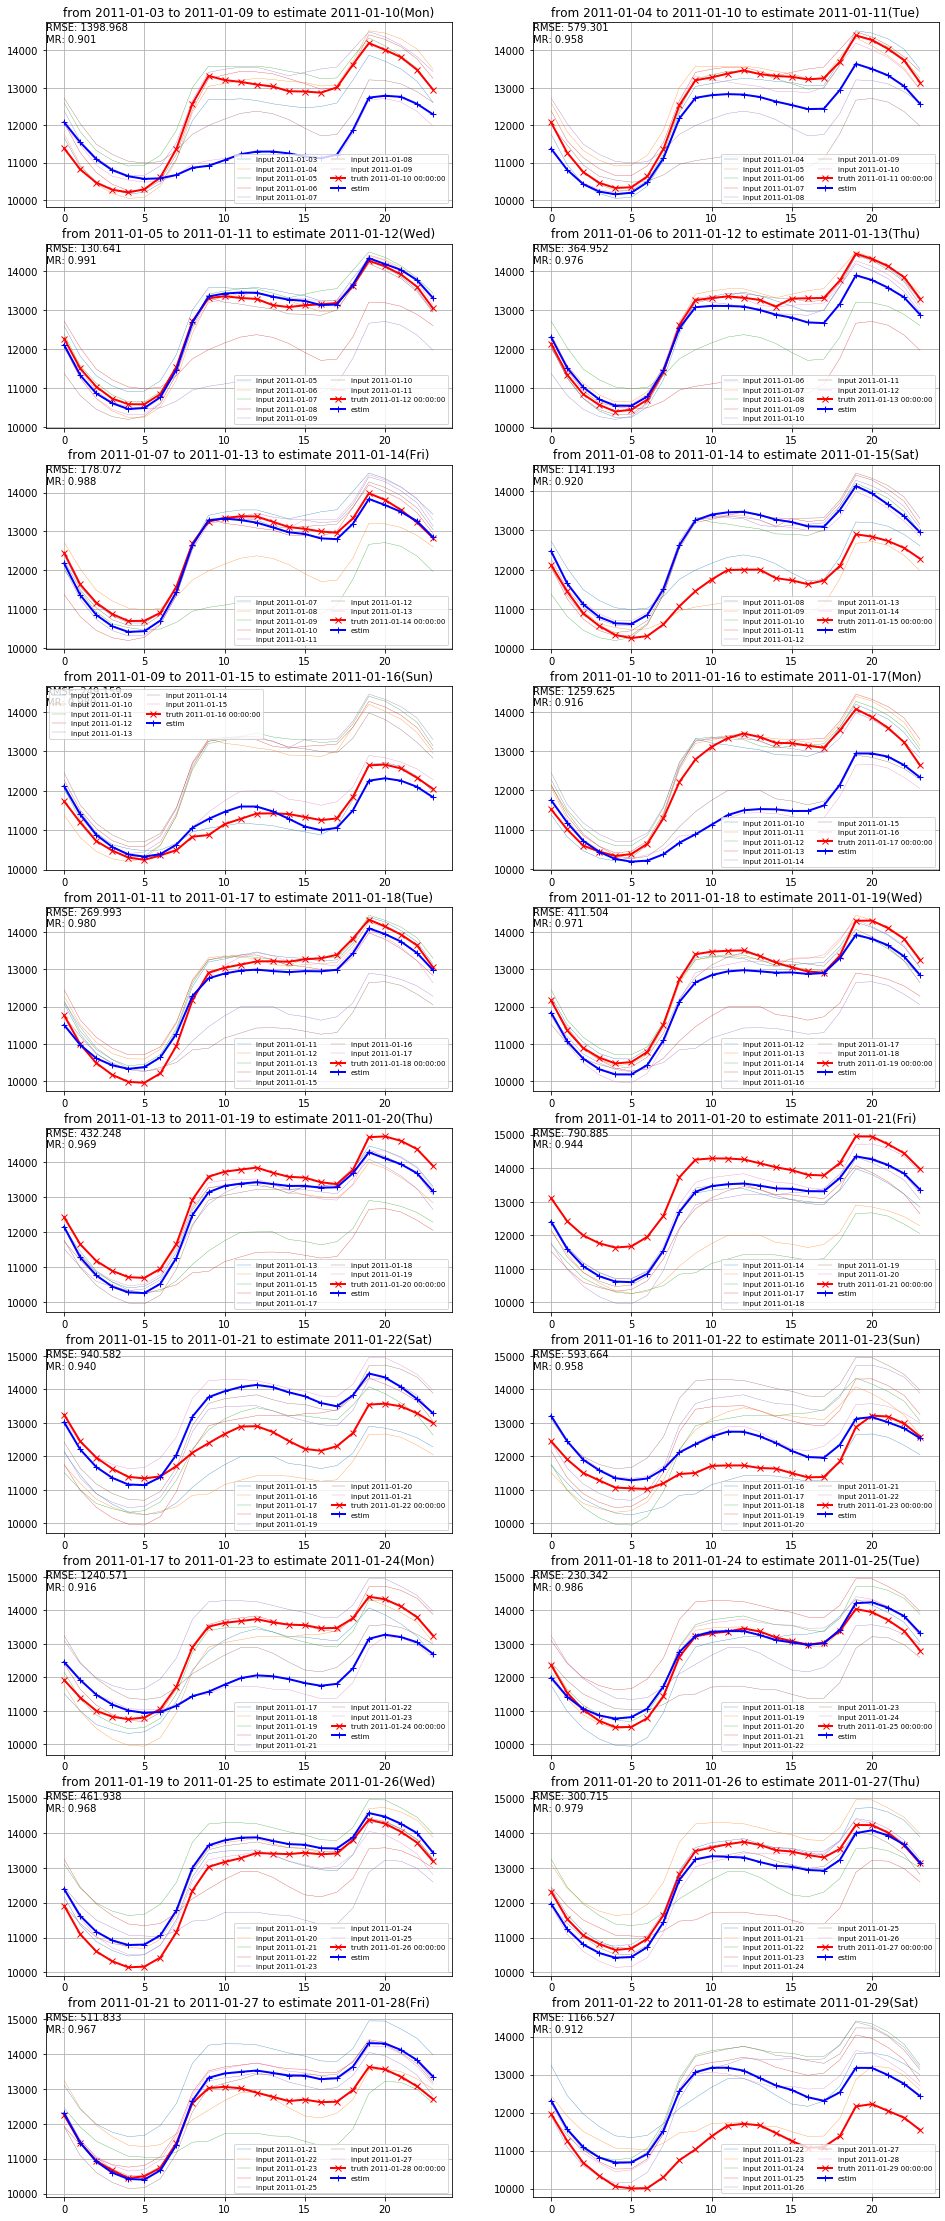

In [11]:
plotter.plot_regression_res(df_feat_trn, df_tar_trn, df_pred_trn, 7, 20)

## open evaluation (testing v estimation from testing data)

In [12]:
ret = pp.post_process_array_to_df(feat_test, pred_test, tar_test, n_days, idx_test)
df_feat_nrm_tst, df_pred_nrm_tst, df_tar_nrm_tst = ret
ret = pp.post_process_inverse_norm(df_feat_nrm_tst, df_pred_nrm_tst, df_tar_nrm_tst, norm_prm_file_name)
df_feat_tst, df_pred_tst, df_tar_tst = ret

2019-11-26 21:17:26,426|INFO|preprocessing.py(145) df_inversed_min_max_norm|transform using parameters from file
2019-11-26 21:17:26,427|INFO|preprocessing.py(260) load|norm_prm_COMED_hourly.pkl loaded.
2019-11-26 21:17:26,428|INFO|preprocessing.py(331) inverse_transform|Inverse MinMax normalisation transforming the data
2019-11-26 21:17:26,448|INFO|preprocessing.py(337) inverse_transform|MinMax normalisation done
2019-11-26 21:17:26,462|INFO|preprocessing.py(145) df_inversed_min_max_norm|transform using parameters from file
2019-11-26 21:17:26,463|INFO|preprocessing.py(260) load|norm_prm_COMED_hourly.pkl loaded.
2019-11-26 21:17:26,464|INFO|preprocessing.py(331) inverse_transform|Inverse MinMax normalisation transforming the data
2019-11-26 21:17:26,467|INFO|preprocessing.py(337) inverse_transform|MinMax normalisation done
2019-11-26 21:17:26,475|INFO|preprocessing.py(145) df_inversed_min_max_norm|transform using parameters from file
2019-11-26 21:17:26,476|INFO|preprocessing.py(260) 

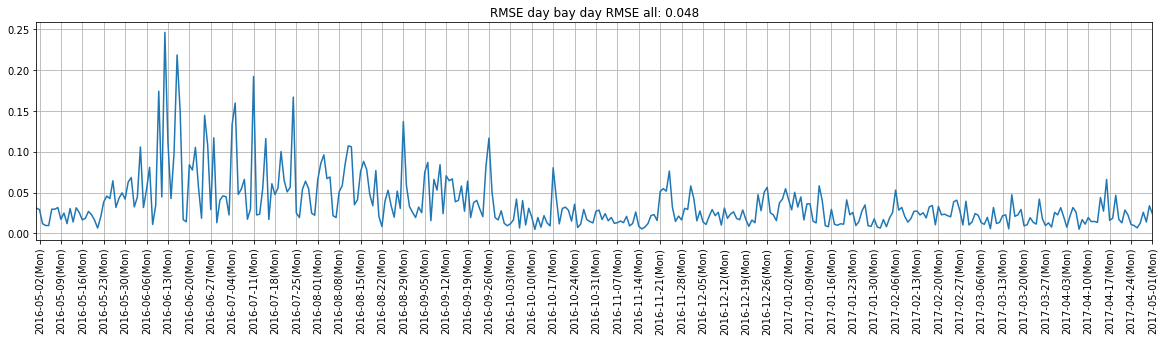

In [13]:
plotter.plot_rmse_day_by_day(df_tar_nrm_tst, df_pred_nrm_tst)

In [14]:
print('RMSE(normalised):', np.sqrt(MSE(df_tar_nrm_tst.values.flatten(), df_pred_nrm_tst.values.flatten())))
print('RMSE            :', np.sqrt(MSE(df_tar_tst.values.flatten(), df_pred_tst.values.flatten())))
print('Match Rate      :', match_rate(df_tar_tst.values.flatten(), df_pred_tst.values.flatten()))

RMSE(normalised): 0.04836465609300937
RMSE            : 798.7906600321427
Match Rate      : 0.9586622268299823


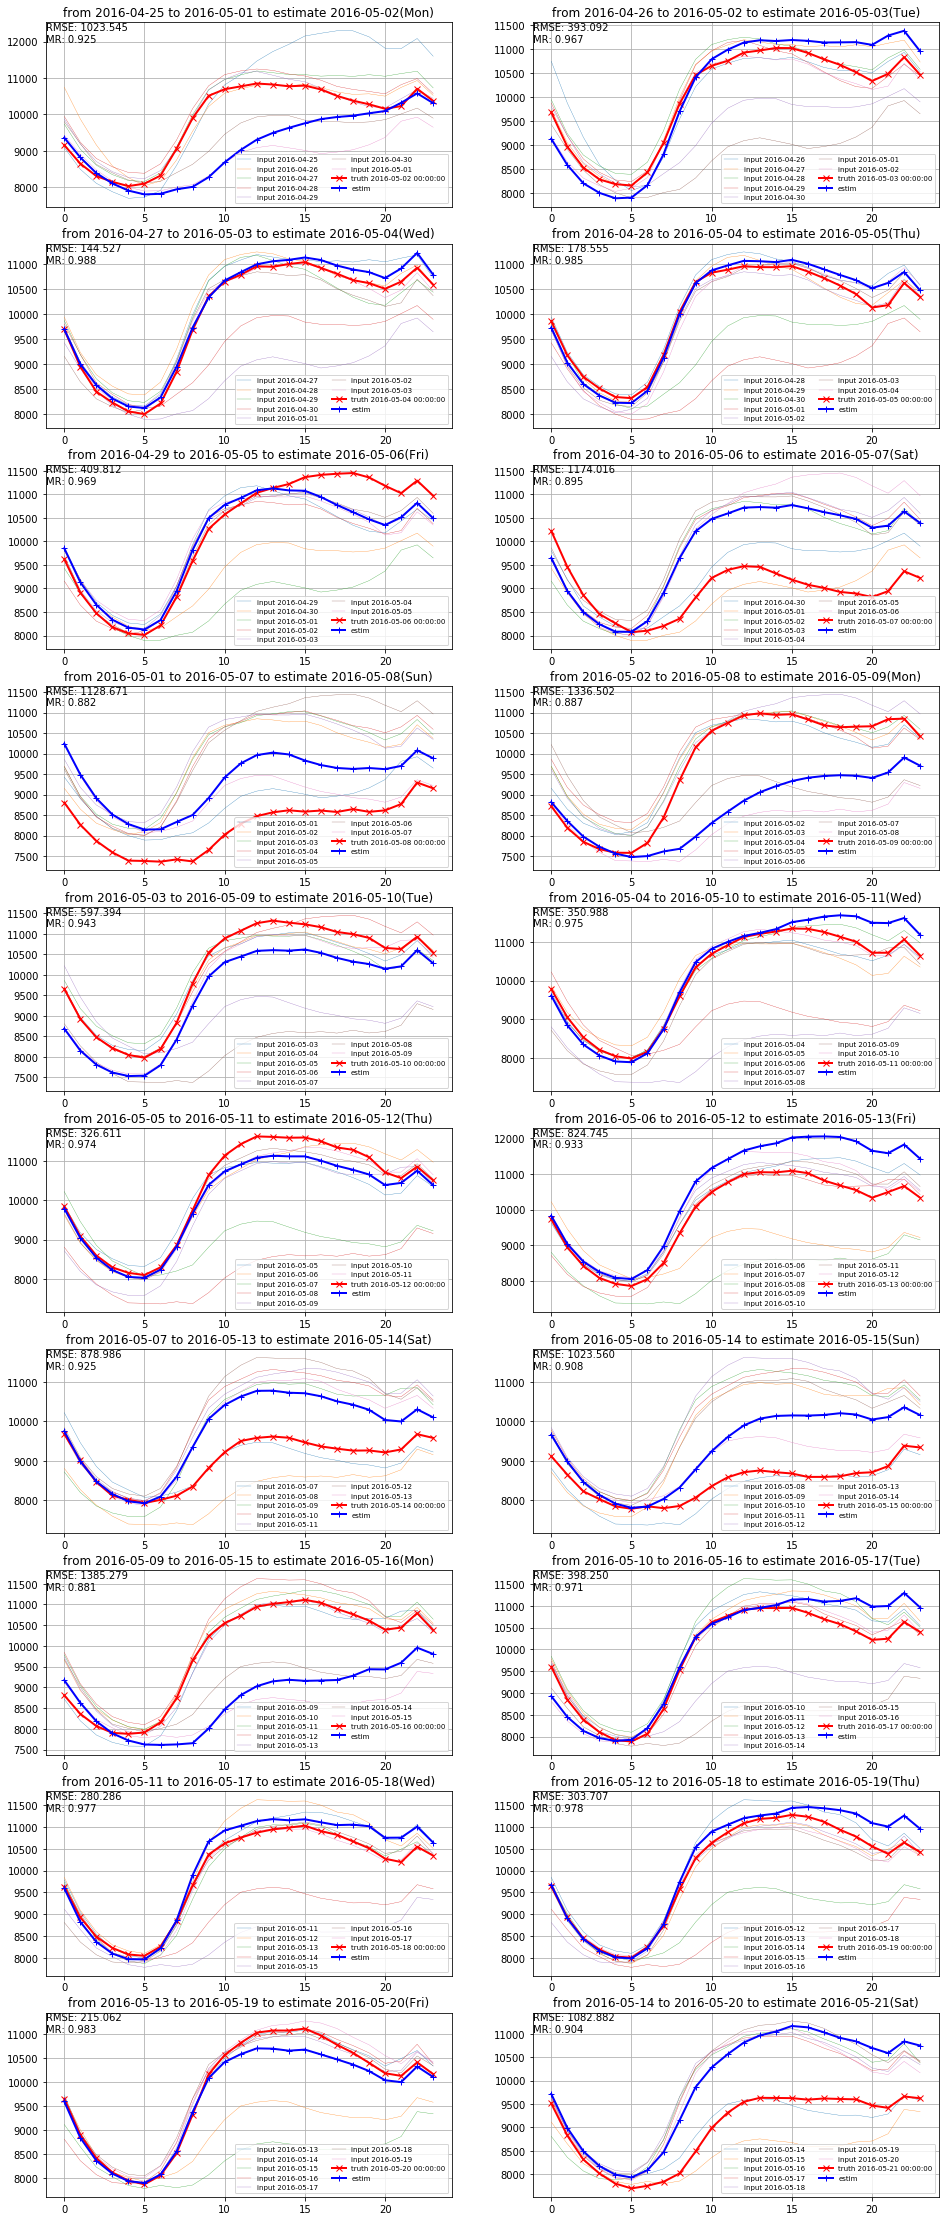

In [15]:
plotter.plot_regression_res(df_feat_tst, df_tar_tst, df_pred_tst, 7, 20)

# Further improvement and feature work
Mondays, Saturdays, and Sundays were not modeled well. Also, the estimations were highly related on previous days. On the other hand, as we discussed in analysis section, there are seasonally trends, weekly trends and daily trends. To model using these information, better feature design is required.

Mondays, Saturdays, and Sundays might be modeled individually, however, this approach can not use the information of previous days. So some methods to intentionally introduce trends may be required. The trends can be treated as prior information. To introduce prior information such as daily trends, we may use Bayesian inference. Bayesian approaches also allow to update the model.

Also, we haven't handled some extra cases such as extreme high power consuming, caused by weather conditions and some events like Super bowl.
To handle these cases and Saturday and Sunday problem, we may want to have some uncertainty to have decisions. Bayesian models or Gaussian processes can give such information. These approaches are worth trying if there is enough time.

Moreover, some external information like temperatures would help. To do this, more time and resources may be required.

For the use case of energy generation, shortage is worse than excess. In order to avoid this, some bias can be given in post process. Also we need to introduce some criteria to evaluate how much and often and shortage happens.

For the use case of energy trading, we can advice that we should be conservative to trade weekends and Mondays.